# Nettoyer et structurer l’information dans les données textuelles

Lino Galiana  
2024-09-23

Les chapitres suivants seront utiles au cours de ce chapitre:

In [1]:
!pip install pywaffle
!pip install spacy
!pip install plotnine
!pip install great_tables
!pip install wordcloud

# 1. Introduction

## 1.1 Rappel

Comme évoqué dans l’[introduction de cette partie](../../content/nlp/index.qmd) sur le traitement automatique du langage, l’objectif principal des techniques que nous allons explorer est la représentation synthétique du langage.

Le *natural language processing* (NLP) ou
*traitement automatisé du langage* (TAL) en Français,
vise à extraire de l’information de textes à partir d’une analyse statistique du contenu.
Cette définition permet d’inclure de nombreux champs d’applications au sein
du NLP (traduction, analyse de sentiment, recommandation, surveillance, etc. ).

Cette approche implique de transformer un texte, qui est une information compréhensible par un humain, en un nombre, information appropriée pour un ordinateur dans le cadre d’une approche statistique ou algorithmique.

Transformer une information textuelle en valeurs numériques propres à une analyse statistique n’est pas une tâche évidente. Les données textuelles sont **non structurées** puisque l’information cherchée, qui est propre à chaque analyse, est perdue au milieu d’une grande masse d’informations qui doit, de plus, être interprétée dans un certain contexte (un même mot ou une phrase n’ayant pas la même signification selon le contexte).

Si cette tâche n’était pas assez difficile comme ça, on peut ajouter d’autres difficultés propres à l’analyse textuelle car ces données sont :

-   **bruitées** : ortographe, fautes de frappe…
-   **changeantes** : la langue évolue avec de nouveaux mots, sens…
-   **complexes** : structures variables, accords…
-   **ambiguës** : synonymie, polysémie, sens caché…
-   **propres à chaque langue** : il n’existe pas de règle de passage unique entre deux langues
-   de **grande dimension** : des combinaisons infinies de séquences de mots

## 1.2 Objectif du chapitre

Dans ce chapitre, nous allons nous restreindre aux
méthodes fréquentistes dans le paradigme *bag of words*. Celles-ci sont un peu *old school* par rapport aux approches plus raffinées que nous évoquerons ultérieurement. Néanmoins, les présenter nous permettra d’évoquer un certain nombre d’enjeux typiques des données textuelles qui restent centraux dans le NLP moderne.

Le principal enseignement à retenir de cette partie est que les données textuelles étant à très haute dimension - le langage étant un objet riche - nous avons besoin de méthodes pour réduire le bruit de nos corpus textuels afin de mieux prendre en compte le signal en leur sein.

Cette partie est une introduction s’appuyant sur quelques ouvrages classiques de la littérature française ou anglo-saxonne. Seront notamment présentées quelques librairies faisant parti de la boite à outil minimale des *data scientists*: `NLTK` et `SpaCy`. Les chapitres suivants permettront de se focaliser sur la modélisation du langage.

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> La librairie SpaCy</h3>

`NTLK` est la librairie historique d’analyse textuelle en `Python`. Elle existe
depuis les années 1990. L’utilisation industrielle du NLP dans le monde
de la *data science* est néanmoins plus récente et doit beaucoup à la collecte
accrue de données non structurées par les réseaux sociaux. Cela a amené à
un renouvellement du champ du NLP, tant dans le monde de la recherche que dans
sa mise en application dans l’industrie de la donnée.

Le *package* [`spaCy`](https://spacy.io/) est l’un des packages qui a permis
cette industrialisation des méthodes de NLP. Conçu autour du concept
de *pipelines* de données, il est beaucoup plus pratique à mettre en oeuvre
pour une chaîne de traitement de données textuelles mettant en oeuvre
plusieurs étapes de transformation des données.

</div>

## 1.3 Méthode

L’analyse textuelle vise à transformer le texte en données
numériques manipulables. Pour cela il est nécessaire de se fixer
une unité sémantique minimale.
Cette unité textuelle peut être le mot ou encore une séquence de *n*
mots (un *ngram*) ou encore une chaîne de caractères (e.g. la
ponctuation peut être signifiante). On parle de **token**.

On peut ensuite utiliser diverses techniques (*clustering*,
classification supervisée) suivant l’objectif poursuivi pour exploiter
l’information transformée. Mais les étapes de nettoyage de texte sont indispensables.
Sinon un algorithme sera incapable de détecter une information pertinente dans l’infini des possibles.

# 2. Bases d’exemple

## 2.1 Le [*Comte de Monte Cristo*](https://fr.wikipedia.org/wiki/Le_Comte_de_Monte-Cristo)

La base d’exemple est le [*Comte de Monte Cristo*](https://fr.wikipedia.org/wiki/Le_Comte_de_Monte-Cristo) d’Alexandre Dumas.
Il est disponible
gratuitement sur le site
[http://www.gutenberg.org *(Project Gutemberg)*](http://www.gutenberg.org/ebooks/author/492) comme des milliers
d’autres livres du domaine public.

La manière la plus simple de le récupérer
est de télécharger avec le *package* `request` le fichier texte et le retravailler
légèrement pour ne conserver que le corpus du livre :

In [2]:
from urllib import request

url = "https://www.gutenberg.org/files/17989/17989-0.txt"
response = request.urlopen(url)
raw = response.read().decode("utf8")

dumas = raw.split(
    "*** START OF THE PROJECT GUTENBERG EBOOK LE COMTE DE MONTE-CRISTO, TOME I ***"
)[1].split(
    "*** END OF THE PROJECT GUTENBERG EBOOK LE COMTE DE MONTE-CRISTO, TOME I ***"
)[
    0
]

import re


def clean_text(text):
    text = text.lower()  # mettre les mots en minuscule
    text = " ".join(text.split())
    return text


dumas = clean_text(dumas)

dumas[10000:10500]

" mes yeux. --vous avez donc vu l'empereur aussi? --il est entré chez le maréchal pendant que j'y étais. --et vous lui avez parlé? --c'est-à-dire que c'est lui qui m'a parlé, monsieur, dit dantès en souriant. --et que vous a-t-il dit? --il m'a fait des questions sur le bâtiment, sur l'époque de son départ pour marseille, sur la route qu'il avait suivie et sur la cargaison qu'il portait. je crois que s'il eût été vide, et que j'en eusse été le maître, son intention eût été de l'acheter; mais je lu"

## 2.2 Le corpus anglo-saxon

Nous allons utiliser une base anglo-saxonne présentant trois auteurs de la littérature fantastique:

-   [Edgar Allan Poe](https://fr.wikipedia.org/wiki/Edgar_Allan_Poe), (*EAP*) ;
-   [HP Lovecraft](https://fr.wikipedia.org/wiki/H._P._Lovecraft) (*HPL*) ;
-   [Mary Wollstonecraft Shelley](https://fr.wikipedia.org/wiki/Mary_Shelley) (*MWS*).

Les données sont disponibles sur un CSV mis à disposition sur [`Github`](https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/blob/master/data/spooky.csv). L’URL pour les récupérer directement est
<https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv>.

Le fait d’avoir un corpus confrontant plusieurs auteurs nous permettra de comprendre la manière dont les nettoyages de données textuelles favorisent les analyses comparatives.

Nous pouvons utiliser le code suivant pour lire et préparer ces données:

In [3]:
import pandas as pd

url = "https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv"
# 1. Import des données
horror = pd.read_csv(url, encoding="latin-1")
# 2. Majuscules aux noms des colonnes
horror.columns = horror.columns.str.capitalize()
# 3. Retirer le prefixe id
horror["ID"] = horror["Id"].str.replace("id", "")
horror = horror.set_index("Id")


``` python
```

Le jeu de données met ainsi en regard un auteur avec une phrase qu’il a écrite :

In [5]:
horror.head()


On peut se rendre compte que les extraits des 3 auteurs ne sont
pas forcément équilibrés dans le jeu de données.
Si on utilise ultérieurement ce corpus pour de la modélisation, il sera nécessaire de tenir compte de ce déséquilibre.

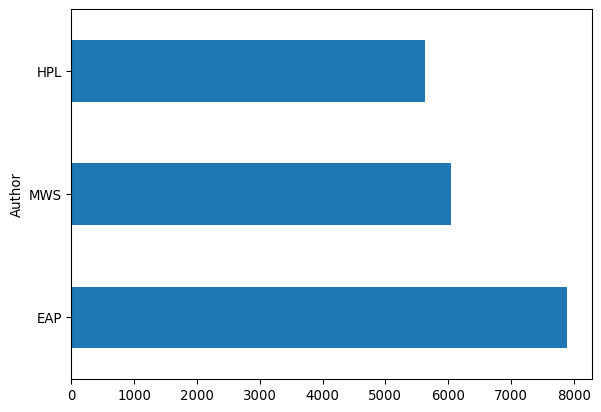

In [6]:
(horror.value_counts("Author").plot(kind="barh"))


# 3. Premières analyses de fréquence

L’approche usuelle en statistique, qui consiste à faire une analyse descriptive avant de mettre en oeuvre une modélisation, s’applique également à l’analyse de données textuelles. La fouille de documents textuels implique ainsi, en premier lieu, une analyse statistique afin de déterminer la structure du corpus.

Avant de s’adonner à une analyse systématique du champ lexical de chaque
auteur, on va se focaliser dans un premier temps sur un unique mot, le mot *fear*.

## 3.1 Exploration ponctuelle

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Tip</h3>

L’exercice ci-dessous présente une représentation graphique nommée
*waffle chart*. Il s’agit d’une approche préférable aux
camemberts (*pie chart*) qui sont des graphiques manipulables car l’oeil humain se laisse
facilement berner par cette représentation graphique qui ne respecte pas
les proportions.

</div>

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1 : Fréquence d’un mot</h3>

Dans un premier temps, nous allons nous concentrer sur notre corpus anglo-saxon (`horror`)

1.  Compter le nombre de phrases, pour chaque auteur, où apparaît le mot `fear`.
2.  Utiliser `pywaffle` pour obtenir les graphiques ci-dessous qui résument
    de manière synthétique le nombre d’occurrences du mot *“fear”* par auteur.
3.  Refaire l’analyse avec le mot *“horror”*.

</div>

In [7]:
# 1. Compter le nombre de phrase pour chaque auteur avec fear
def nb_occurrences(word, train_data):
    train_data["wordtoplot"] = train_data["Text"].str.contains(word).astype(int)
    table = train_data.groupby("Author").sum(numeric_only=True)
    data = table.to_dict()["wordtoplot"]
    return table


table = nb_occurrences("fear", horror)


Le comptage obtenu devrait être le suivant

In [8]:
table.head()


In [9]:
import matplotlib.pyplot as plt
from pywaffle import Waffle


# 2. Faire un graphique d'occurences avc pywaffle
def graph_occurrence(word, train_data):
    table = nb_occurrences(word, train_data)
    data = table.to_dict()["wordtoplot"]
    fig = plt.figure(
        FigureClass=Waffle,
        rows=15,
        values=data,
        title={
            "label": 'Utilisation du mot "%s" par les auteurs' % word,
            "loc": "left",
        },
        labels=[f"{k} ({v})" for k, v in data.items()],
    )
    return fig


fig = graph_occurrence("fear", horror)


Ceci permet d’obtenir le *waffle chart* suivant :

On remarque ainsi de manière très intuitive
le déséquilibre de notre jeu de données
lorsqu’on se focalise sur le terme *“peur”*
où Mary Shelley représente près de 50%
des observations.

Si on reproduit cette analyse avec le terme *“horror”*, on retrouve la figure suivante:

In [11]:
# 3. Graphe d'occurences avec le mot horror
fig = graph_occurrence("horror", horror)


In [12]:
fig.get_figure()


## 3.2 Transformation d’un texte en *tokens*

Dans l’exercice précédent, nous faisions une recherche ponctuelle, qui ne passe pas vraiment à l’échelle. Pour généraliser cette approche, on découpe généralement un corpus en unités sémantiques indépendantes : les *tokens*.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Tip</h3>

Nous allons avoir besoin d’importer un certain nombre de corpus prêts à l’emploi pour utiliser les librairies `NTLK` ou `SpaCy`. Les instructions ci-dessous permettront de récupérer toutes ces ressources

</div>

Pour récupérer tous nos corpus `NLTK` prêts à l’emploi, nous faisons

In [13]:
import nltk

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("genesis")
nltk.download("wordnet")
nltk.download("omw-1.4")


En ce qui concerne `SpaCy`, il est nécessaire d’utiliser
la ligne de commande:

In [14]:
!python -m spacy download fr_core_news_sm
!python -m spacy download en_core_web_sm

Plutôt que d’implémenter soi-même un *tokenizer* inefficace, il est plus approprié d’en appliquer un issu d’une librairie spécialisée. Historiquement, le plus simple était de prendre le *tokenizer* de `NLTK`, la librairie historique de *text mining* en `Python`:

In [15]:
from nltk.tokenize import word_tokenize

word_tokenize(dumas[10000:10500])


Comme on le voit, cette librairie ne fait pas les choses dans le détail et a quelques incohérences: `j'y étais` est séparé en 4 sèmes (`['j', "'", 'y', 'étais']`) là où `l'acheter` reste un unique sème. `NLTK` est en effet une librairie anglo-saxonne et l’algorithme de séparation n’est pas toujours adapté aux règles grammaticales françaises. Il vaut mieux dans ce cas privilégier `SpaCy`, la librairie plus récente pour faire ce type de tâche. En plus d’être très bien documentée, elle est mieux adaptée pour les langues non anglo-saxonnes. En l’occurrence, comme le montre l’[exemple de la documentation](https://spacy.io/usage/linguistic-features#tokenization) sur les *tokenizers*, l’algorithme de séparation présente un certain raffinement

<figure>
<img src="https://spacy.io/images/tokenization.svg" alt="Exemple d’algorithme de tokenisation" />
<figcaption aria-hidden="true">Exemple d’algorithme de tokenisation</figcaption>
</figure>

Celui-ci peut être appliqué de cette manière:

In [16]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("fr_core_news_sm")
doc = nlp(dumas[10000:10500])

text_tokenized = []
for token in doc:
    text_tokenized += [token.text]

", ".join(text_tokenized)


" , mes, yeux, ., --vous, avez, donc, vu, l', empereur, aussi, ?, --il, est, entré, chez, le, maréchal, pendant, que, j', y, étais, ., --et, vous, lui, avez, parlé, ?, --c', est, -, à, -, dire, que, c', est, lui, qui, m', a, parlé, ,, monsieur, ,, dit, dantès, en, souriant, ., --et, que, vous, a, -t, -il, dit, ?, --il, m', a, fait, des, questions, sur, le, bâtiment, ,, sur, l', époque, de, son, départ, pour, marseille, ,, sur, la, route, qu', il, avait, suivie, et, sur, la, cargaison, qu', il, portait, ., je, crois, que, s', il, eût, été, vide, ,, et, que, j', en, eusse, été, le, maître, ,, son, intention, eût, été, de, l', acheter, ;, mais, je, lu"

Comme on peut le voir, il reste encore beaucoup d’éléments polluants notre structuration de corpus, à commencer par la ponctuation. Nous allons néanmoins pouvoir facilement retirer ceux-ci ultérieurement, comme nous le verrons.

## 3.3 Le nuage de mot: une première analyse généralisée

A ce stade, nous n’avons encore aucune appréhension de la structure de notre corpus : nombre de mots, mots les plus représentés, etc.

Pour se faire une idée de la structure de notre corpus,
on peut commencer par compter la distribution des mots dans l’oeuvre de Dumas. Commençons par le début de l’oeuvre, à savoir les 30 000 premiers mots et comptons les mots uniques :

In [17]:
from collections import Counter

doc = nlp(dumas[:30000])

# Extract tokens, convert to lowercase and filter out punctuation and spaces
tokens = [
    token.text.lower() for token in doc if not token.is_punct and not token.is_space
]

# Count the frequency of each token
token_counts = Counter(tokens)


Nous avons déjà de nombreux mots différents dans le début de l’oeuvre.

In [18]:
len(token_counts)


1401

Nous voyons la haute dimensionnalité du corpus puisque nous avons près de 1500 mots différents sur les 30 000 premiers mots de l’oeuvre de Dumas.

In [19]:
token_count_all = list(token_counts.items())

# Create a DataFrame from the list of tuples
token_count_all = pd.DataFrame(token_count_all, columns=["word", "count"])


Si on regarde la distribution de la fréquence des mots, exercice que nous prolongerons ultérieurement en évoquant la [loi de Zipf](https://fr.wikipedia.org/wiki/Loi_de_Zipf), nous pouvons voir que de nombreux mots sont unique (près de la moitié des mots), que la densité de fréquence descend vite et qu’il faudrait se concentrer un peu plus sur la queue de distribution que ne le permet la figure suivante :

/opt/mamba/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 42'. Pick better value with 'binwidth'.

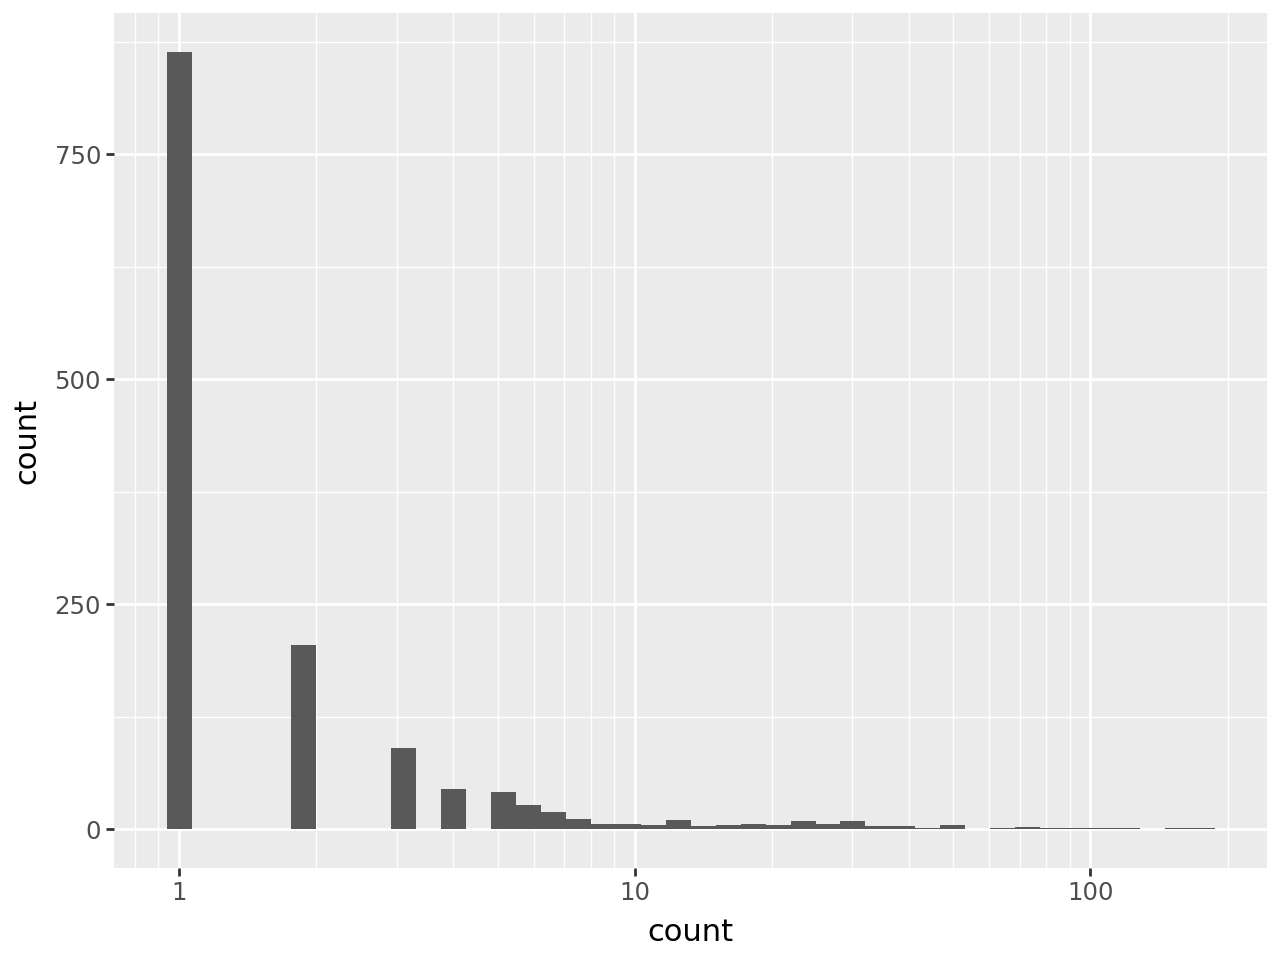

In [20]:
from plotnine import *

(ggplot(token_count_all) + geom_histogram(aes(x="count")) + scale_x_log10())


Maintenant, si on regarde les 25 mots les plus fréquents, on peut voir que ceux-ci ne sont pas très intéressants pour analyser le sens de notre document :

In [21]:
# Sort the tokens by frequency in descending order
sorted_token_counts = token_counts.most_common(25)
sorted_token_counts = pd.DataFrame(sorted_token_counts, columns=["word", "count"])


In [22]:
from great_tables import GT, md
import polars as pl


def create_bar(prop_fill: float, max_width: int, height: int) -> str:
    """Create divs to represent prop_fill as a bar."""
    width = round(max_width * prop_fill, 2)
    px_width = f"{width}px"
    return f"""\
    <div style="width: {max_width}px; background-color: lightgrey;">\
        <div style="height:{height}px;width:{px_width};background-color:green;"></div>\
    </div>\
    """


sorted_token_counts["count_pct"] = (
    sorted_token_counts["count"] / sorted_token_counts["count"].max()
)

df = (
    pl.from_pandas(sorted_token_counts)
    .with_columns(
        pl.col("count_pct")
        .map_elements(lambda x: create_bar(x, max_width=75, height=20))
        .alias("count_pct_bar")
    )
    .with_columns(
        pl.col("count_pct").map_elements(lambda x: f"__{x}__").alias("count_pct")
    )
)

(
    GT(df)
    .cols_hide("count_pct")
    .cols_label(**{"count_pct_bar": "", "word": "Mot", "count": "Nombre d'occurrences"})
    .tab_source_note(
        md(
            "_Nombre d'apparitions sur les 30 000 premiers caractères du Comte de Monte Cristo_"
        )
    )
    .fmt_markdown("word")
)


/tmp/ipykernel_11171/3224890599.py:18: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
/tmp/ipykernel_11171/3224890599.py:23: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.

Si on représente graphiquement ce classement

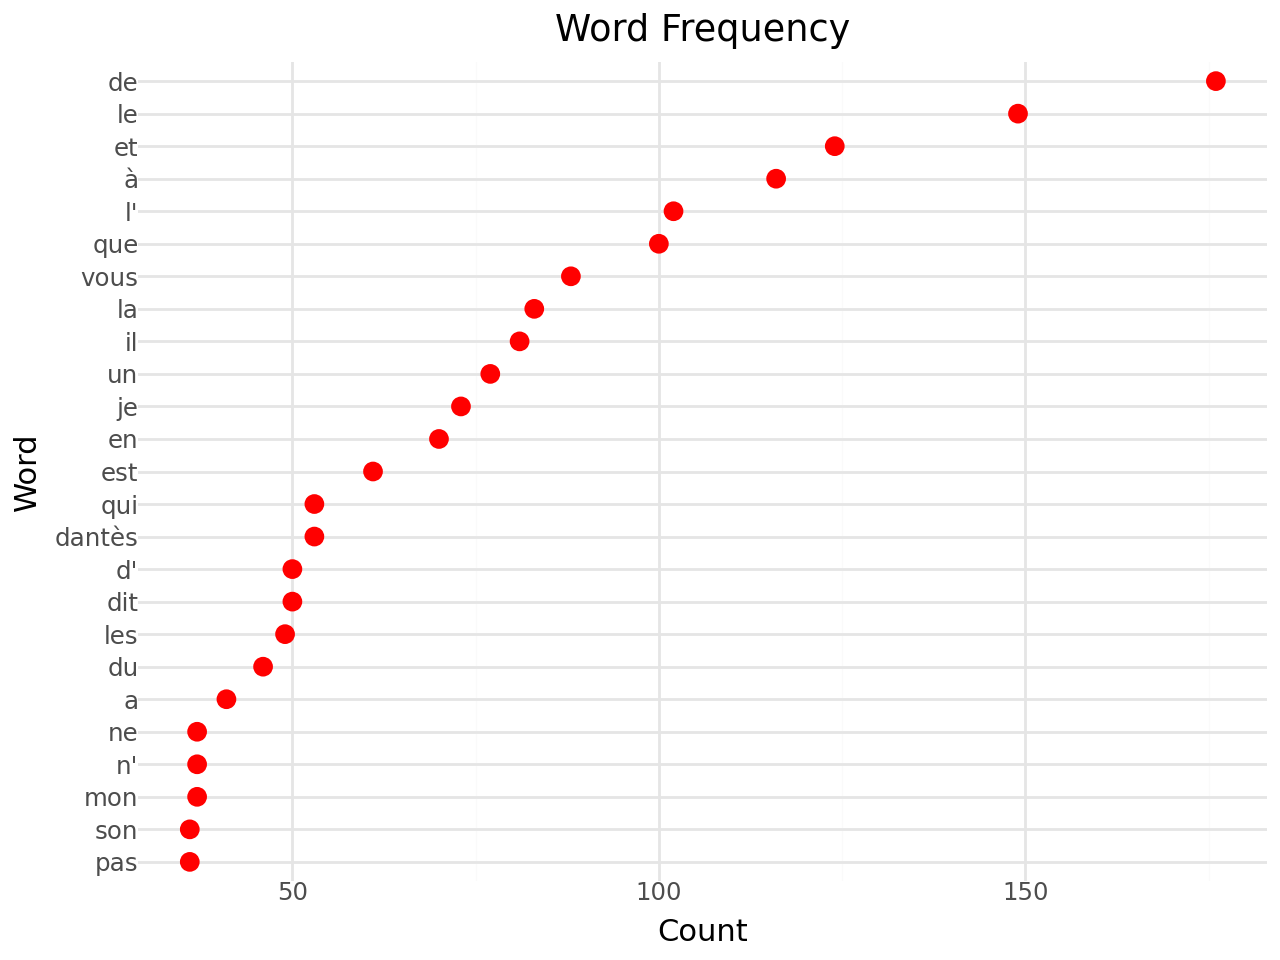

In [23]:
(
    ggplot(sorted_token_counts, aes(x="word", y="count"))
    + geom_point(stat="identity", size=3, color="red")
    + scale_x_discrete(limits=sorted_token_counts.sort_values("count")["word"].tolist())
    + coord_flip()
    + theme_minimal()
    + labs(title="Word Frequency", x="Word", y="Count")
)


Nous nous concentrerons ultérieurement sur ces mots-valises car il sera important d’en tenir compte pour les analyses approfondies de nos documents.

Nous avons pu, par ces décomptes de mots, avoir une première intutition de la nature de notre corpus. Néanmoins, une approche un peu plus visuelle serait pertinente pour avoir un peu plus d’intuitions.
Les nuages de mots (*wordclouds*) sont des représentations graphiques assez pratiques pour visualiser
les mots les plus fréquents, lorsqu’elles ne sont pas utilisées à tort et à travers.
Les *wordclouds* sont très simples à implémenter en `Python`
avec le module `Wordcloud`. Quelques paramètres de mise en forme
permettent même d’ajuster la forme du nuage à
une image.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 3 : Wordcloud</h3>

1.  En utilisant la fonction `wordCloud`, faire trois nuages de mot pour représenter les mots les plus utilisés par chaque auteur du corpus `horror`[1].
2.  Faire un nuage de mot du corpus `dumas` en utilisant un masque
    comme celui-ci

<details>

<summary>

Exemple de masque pour la question 2

</summary>

<figure>
<img src="https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/book.png" alt="URL de l’image: https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/book.png" />
<figcaption aria-hidden="true">URL de l’image: https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/book.png</figcaption>
</figure>

</details>

</div>

[1] Pour avoir les mêmes résultats que ci-dessous, vous pouvez fixer l’argument `random_state=21`.

In [24]:
from wordcloud import WordCloud


# 1. Wordclouds trois auteurs
def graph_wordcloud(author, train_data, varname="Text"):
    txt = train_data.loc[train_data["Author"] == author, varname]
    all_text = " ".join([text for text in txt])
    wordcloud = WordCloud(
        width=800,
        height=500,
        random_state=21,
        max_words=2000,
        background_color="white",
        colormap="Set2",
    ).generate(all_text)
    return wordcloud


n_topics = ["HPL", "EAP", "MWS"]


Les nuages de points obtenus à la question 1 sont les suivants:

``` python
for i in range(len(n_topics)):
    wordcloud = graph_wordcloud(n_topics[i], horror)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
```

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div class="cell-output cell-output-display" width="50.0%" data-layout-align="left">
<figure id="fig-wordcloud-spooky">
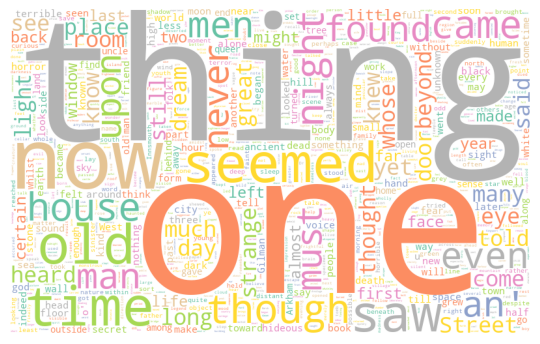
<figcaption>Figure 3.3: Lovercraft</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div class="cell-output cell-output-display" width="50.0%" data-layout-align="left">
<figure id="fig-wordcloud-spooky">
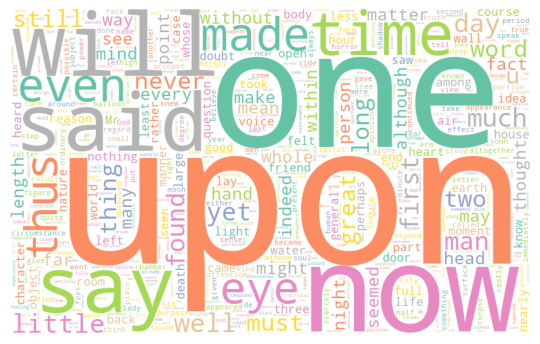
<figcaption>Figure 3.4: Poe</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table style="width:50%;">
<colgroup>
<col style="width: 50%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div class="cell-output cell-output-display" width="50.0%" data-layout-align="left">
<figure id="fig-wordcloud-spooky">
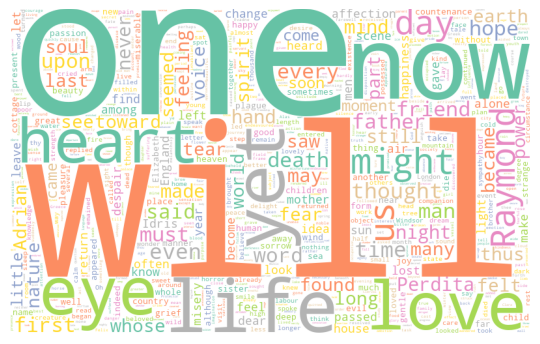
<figcaption>Figure 3.5: Shelley</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

In [26]:
import wordcloud
import numpy as np
import io
import requests
import PIL
import matplotlib.pyplot as plt

img = "https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/book.png"
book_mask = np.array(PIL.Image.open(io.BytesIO(requests.get(img).content)))


def make_wordcloud(corpus):
    wc = wordcloud.WordCloud(
        background_color="white",
        max_words=2000,
        mask=book_mask,
        contour_width=3,
        contour_color="steelblue",
    )
    wc.generate(corpus)
    return wc


wordcloud_dumas = make_wordcloud(dumas)


Alors que celui obtenu à partir de l’oeuvre de Dumas prend
la forme

In [27]:
plt.imshow(wordcloud_dumas, interpolation="bilinear")
plt.axis("off")


Si nous n’en étions pas convaincus, ces visualisations montrent clairement qu’il est nécessaire de nettoyer notre texte. Par exemple, en ce qui concerne l’oeuvre du Dumas, le nom
du personnage principal, Dantès, est ainsi masqué par un certain nombre d’articles ou mots de liaison qui perturbent l’analyse.
En ce qui concerne le corpus anglo-saxon, ce sont des termes similaires, comme *“the”*, *“of”*, etc.

Ces mots sont des
*stop words*.
Ceci est une démonstration par l’exemple qu’il vaut mieux nettoyer le texte avant de
l’analyser (sauf si on est intéressé
par la loi de Zipf, cf. exercice suivant).

## 3.4 Aparté: la loi de Zipf

Zipf, dans les années 1930, a remarqué une régularité statistique dans *Ulysse*, l’oeuvre de Joyce. Le mot le plus fréquent apparaissait $x$ fois, le deuxième mot le plus fréquent 2 fois moins, le suivant 3 fois moins que le premier, etc. D’un point de vue statistique, cela signifie que la fréquence d’occurrence $f(n_i)$ d’un mot est
liée à son rang $n_i$ dans l’ordre des fréquences par une loi de la forme

$$f(n_i) = c/n_i$$

où $c$ est une constante.

Plus généralement, on peut dériver la loi de Zipf d’une distribution exponentiellement décroissante des fréquences : $f(n_i) = cn_{i}^{-k}$. Sur le plan empirique, cela signifie qu’on peut utiliser les régressions poissonniennes pour estimer les paramètres de la loi, ce qui prend la spécification suivante

$$
\mathbb{E}\bigg( f(n_i)|n_i \bigg) = \exp(\beta_0 + \beta_1 \log(n_i))
$$

Les modèles linéaires généralisés (GLM) permettent de faire ce type de régression. En `Python`, ils sont disponibles par le biais du *package* `statsmodels`, dont les sorties sont très inspirées des logiciels payants spécialisés dans l’économétrie comme `Stata`.

In [28]:
count_words = pd.DataFrame(
    {
        "counter": horror.groupby("Author")
        .apply(lambda s: " ".join(s["Text"]).split())
        .apply(lambda s: Counter(s))
        .apply(lambda s: s.most_common())
        .explode()
    }
)
count_words[["word", "count"]] = pd.DataFrame(
    count_words["counter"].tolist(), index=count_words.index
)
count_words = count_words.reset_index()

count_words = count_words.assign(
    tot_mots_auteur=lambda x: (x.groupby("Author")["count"].transform("sum")),
    freq=lambda x: x["count"] / x["tot_mots_auteur"],
    rank=lambda x: x.groupby("Author")["count"].transform("rank", ascending=False),
)


/tmp/ipykernel_11171/4009929367.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

Commençons par représenter la relation entre la fréquence et le rang:

In [29]:
from plotnine import *

g = (
    ggplot(count_words)
    + geom_point(aes(y="freq", x="rank", color="Author"), alpha=0.4)
    + scale_x_log10()
    + scale_y_log10()
    + theme_minimal()
)


Nous avons bien, graphiquement, une relation log-linéaire entre les deux :

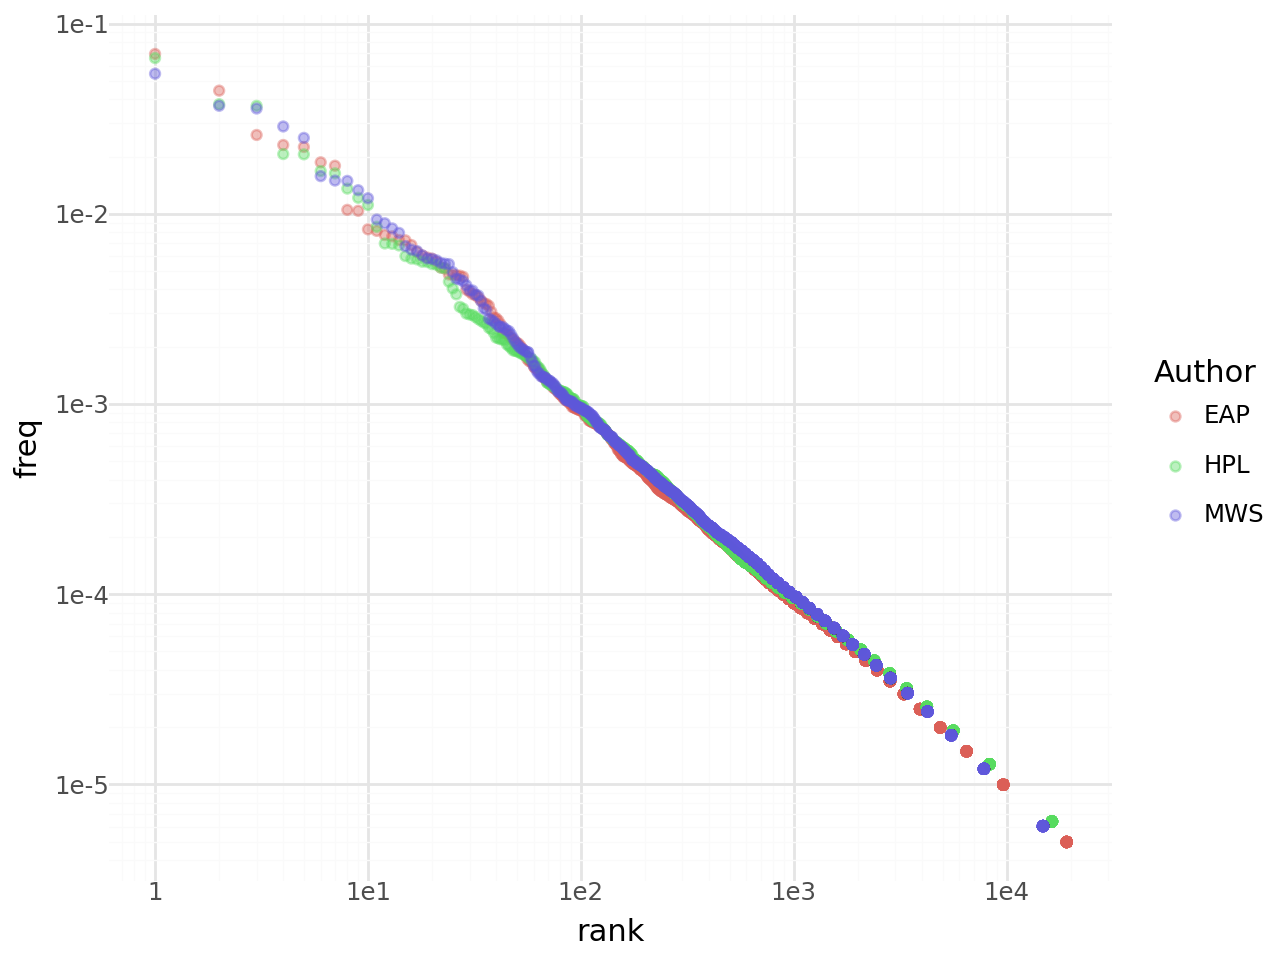

In [30]:
g


Avec `statsmodels`, vérifions plus formellement cette relation:

In [31]:
import statsmodels.api as sm
import numpy as np

exog = sm.add_constant(np.log(count_words["rank"].astype(float)))

model = sm.GLM(
    count_words["freq"].astype(float), exog, family=sm.families.Poisson()
).fit()

# Afficher les résultats du modèle
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   freq   No. Observations:                69301
Model:                            GLM   Df Residuals:                    69299
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.011
Date:                Mon, 23 Sep 2024   Deviance:                     0.065676
Time:                        21:44:30   Pearson chi2:                   0.0656
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0002431
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4388      1.089     -2.239      0.0

Le coefficient de la régression est presque 1 ce qui suggère bien une relation
quasiment log-linéaire entre le rang et la fréquence d’occurrence d’un mot.
Dit autrement, le mot le plus utilisé l’est deux fois plus que le deuxième mot le plus fréquent qui l’est trois plus que le troisième, etc. On retrouve bien empiriquement cette loi sur ce corpus de trois auteurs.

# 4. Nettoyage de textes

## 4.1 Retirer les *stop words*

Nous l’avons vu, que ce soit en Français ou Anglais,
un certain nombre de mots de liaisons, nécessaires sur le plan grammatical mais peu porteur d’information, nous empêchent de saisir les principaux mots vecteurs d’information dans notre corpus.

Il est donc nécessaire de nettoyer notre corpus en retirant ces termes. Ce travail de nettoyage va d’ailleurs au-delà d’un simple retrait de mots. C’est également l’occasion de retirer d’autres sèmes gênants, par exemple la ponctuation.

Commençons par télécharger le corpus de *stopwords*

In [32]:
import nltk

nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /github/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

True

La liste des *stopwords* anglais dans `NLTK`
est la suivante:

In [33]:
from nltk.corpus import stopwords

", ".join(stopwords.words("english"))


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

Celle de `SpaCy` est plus riche (nous avons déjà téléchargé le corpus `en_core_web_sm` en question):

In [34]:
nlp_english = spacy.load("en_core_web_sm")
stop_words_english = nlp_english.Defaults.stop_words
", ".join(stop_words_english)


"none, whether, whenever, thence, this, before, why, was, last, against, ca, also, upon, where, had, about, say, unless, their, made, few, thereby, across, by, still, they, hereupon, a, ten, within, everyone, without, would, with, former, 've, one, up, those, whereupon, above, done, she, yet, hereby, fifteen, very, does, hundred, them, serious, never, nobody, seemed, whence, wherever, wherein, eight, really, n’t, name, herself, ‘ll, hers, keep, seem, afterwards, although, we, whither, latter, nothing, another, others, ’d, am, its, which, two, around, what, for, back, same, see, becoming, on, though, nine, can, fifty, ’ve, anyone, well, behind, side, becomes, hence, not, only, many, various, each, he, these, go, even, along, amount, somewhere, ’re, toward, anywhere, six, enough, over, itself, mine, yourself, here, using, used, every, seems, meanwhile, it, further, nowhere, otherwise, 's, off, alone, much, first, sometimes, of, please, three, there, no, per, make, will, i, n't, neverthel

Si cette fois on prend la liste des *stopwords* français dans `NLTK`:

In [35]:
", ".join(stopwords.words("french"))


'au, aux, avec, ce, ces, dans, de, des, du, elle, en, et, eux, il, ils, je, la, le, les, leur, lui, ma, mais, me, même, mes, moi, mon, ne, nos, notre, nous, on, ou, par, pas, pour, qu, que, qui, sa, se, ses, son, sur, ta, te, tes, toi, ton, tu, un, une, vos, votre, vous, c, d, j, l, à, m, n, s, t, y, été, étée, étées, étés, étant, étante, étants, étantes, suis, es, est, sommes, êtes, sont, serai, seras, sera, serons, serez, seront, serais, serait, serions, seriez, seraient, étais, était, étions, étiez, étaient, fus, fut, fûmes, fûtes, furent, sois, soit, soyons, soyez, soient, fusse, fusses, fût, fussions, fussiez, fussent, ayant, ayante, ayantes, ayants, eu, eue, eues, eus, ai, as, avons, avez, ont, aurai, auras, aura, aurons, aurez, auront, aurais, aurait, aurions, auriez, auraient, avais, avait, avions, aviez, avaient, eut, eûmes, eûtes, eurent, aie, aies, ait, ayons, ayez, aient, eusse, eusses, eût, eussions, eussiez, eussent'

On voit que celle-ci n’est pas très riche et mériterait d’être plus complète. Celle de `SpaCy` correspond mieux à ce qu’on attend

In [36]:
stop_words_french = nlp.Defaults.stop_words
", ".join(stop_words_french)


"etant, ils, dehors, nos, ou, eu, puisque, siens, basee, différente, toute, lès, laisser, quatre-vingt, sera, chacun, duquel, dite, sauf, après, anterieures, vé, concernant, merci, ouvert, permet, dixième, certes, comme, té, quant-à-soi, tel, possible, reste, où, specifiques, a, avec, ton, cependant, spécifique, là, mienne, ho, deux, étaient, toujours, ma, peu, suffisante, désormais, hue, mille, quoi, l’, feront, font, auxquelles, quinze, desquels, pour, rendre, derriere, sans, miens, excepté, douze, préalable, sont, devra, ainsi, abord, quoique, je, revoici, seulement, eh, suis, quant, vos, durant, auxquels, autrui, ayant, celle-là, déja, hou, sienne, le, ô, s', laquelle, pense, ouverte, certaines, par, semble, lequel, ses, faisant, dès, son, seront, neanmoins, assez, tenant, dits, toutes, facon, ouste, pu, quelques, seuls, vers, parlent, bat, entre, et, antérieure, moi, on, une, cinq, pourrait, un, tant, vingt, tienne, qu’, onzième, donc, divers, car, dit, quatrièmement, bas, enfin, 

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 4 : Nettoyage du texte</h3>

1.  Reprendre l’ouvrage de Dumas et nettoyer celui-ci avec `Spacy`. Refaire le nuage de mots et conclure.
2.  Faire ce même exercice sur le jeu de données anglo-saxon. Idéalement, vous devriez être en mesure d’utiliser la fonctionnalité de *pipeline* de `SpaCy`.

</div>

``` python
```

In [37]:
del clean_text


def clean_text(doc):
    # Tokenize, remove stop words and punctuation, and lemmatize
    cleaned_tokens = [
        token.lemma_ for token in doc if not token.is_stop and not token.is_punct
    ]
    # Join tokens back into a single string
    cleaned_text = " ".join(cleaned_tokens)
    return cleaned_text


In [38]:
# Process the text with spaCy
doc = nlp(dumas[:30000], disable=["ner", "textcat"])

# Clean the text
cleaned_dumas = clean_text(doc)


In [39]:
wordcloud_dumas_nostop = make_wordcloud(cleaned_dumas)


Ces retraitements commencent à porter leurs fruits puisque des mots ayant plus
de sens commencent à se dégager, notamment les noms des personnages
(Dantès, Danglart, etc.):

In [40]:
plt.imshow(wordcloud_dumas_nostop, interpolation="bilinear")
plt.axis("off")


In [41]:
# Question 2
docs = nlp_english.pipe(horror["Text"])
cleaned_texts = [clean_text(doc) for doc in docs]
horror["preprocessed_text"] = cleaned_texts


In [42]:
fig = plt.figure(figsize=(15, 12))
for i in range(len(n_topics)):
    wordcloud = graph_wordcloud(n_topics[i], horror, "preprocessed_text")
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


## 4.2 Racinisation et lemmatisation

Pour aller plus loin dans l’harmonisation d’un texte, il est possible de
mettre en place des classes d’équivalence entre des mots. Par exemple, quand on désire faire une analyse fréquentiste, on peut être intéressé par considérer que *“cheval”* et *“chevaux”* sont équivalents. Selon les cas, différentes formes d’un même mot (pluriel,
singulier, conjugaison) pourront être considérées comme équivalentes et seront remplacées par une
même forme dite canonique.

Il existe deux approches dans le domaine :

-   la **lemmatisation** qui requiert la connaissance des statuts
    grammaticaux (exemple : *“chevaux”* devient *“cheval”*) ;
-   la **racinisation** (*stemming*) plus fruste mais plus rapide, notamment
    en présence de fautes d’orthographes. Dans ce cas, *“chevaux”* peut devenir *“chev”*
    mais être ainsi confondu avec *“chevet”* ou *“cheveux”*.

Cette approche a l’avantage de réduire la taille du vocabulaire à maîtriser
pour l’ordinateur et le modélisateur. Il existe plusieurs algorithmes de
*stemming*, notamment le *Porter Stemming Algorithm* ou le
*Snowball Stemming Algorithm*.

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Note</h3>

Pour disposer du corpus nécessaire à la lemmatisation, il faut, la première fois,
télécharger celui-ci grâce aux commandes suivantes :

``` python
import nltk

nltk.download("wordnet")
nltk.download("omw-1.4")
```

</div>

Prenons cette chaine de caractère,

In [43]:
dumas[1030:1200]


"naples. comme d'habitude, un pilote côtier partit aussitôt du port, rasa le château d'if, et alla aborder le navire entre le cap de morgion et l'île de rion. aussitôt, co"

La version racinisée est la suivante:

In [44]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language="french")

stemmed = [stemmer.stem(word) for word in word_tokenize(dumas[1030:1200])]
",".join(stemmed)


"napl,.,comm,d'habitud,,,un,pilot,côti,part,aussitôt,du,port,,,ras,le,château,d'if,,,et,alla,abord,le,navir,entre,le,cap,de,morgion,et,l'îl,de,rion,.,aussitôt,,,co"

A ce niveau, les mots commencent à être moins intelligibles par un humain
mais peuvent rester intelligible pour la machine. Ce choix n’est néanmoins pas neutre et sa pertinence dépend du cas d’usage.

Les lemmatiseurs permettront des harmonisations plus subtiles. Ils s’appuient sur des bases de connaissance, par exemple *WordNet*, une base
lexicographique ouverte. Par exemple, les mots *“women”*, *“daughters”*
et *“leaves”* seront ainsi lemmatisés de la manière suivante :

In [45]:
from nltk.stem import WordNetLemmatizer

lemm = WordNetLemmatizer()

for word in ["women", "daughters", "leaves"]:
    print(f"The lemmatized form of {word} is: {lemm.lemmatize(word)}")


The lemmatized form of women is: woman
The lemmatized form of daughters is: daughter
The lemmatized form of leaves is: leaf

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 5 : Lemmatisation avec nltk</h3>

Sur le modèle précédent, utiliser un `WordNetLemmatizer` sur le corpus `dumas[1030:1200]` et observer le résultat.

</div>

La version lemmatisée de ce petit morceau de l’oeuvre de Dumas est la suivante:

In [46]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

lemmatized = [lemmatizer.lemmatize(word) for word in word_tokenize(dumas[1030:1200])]
", ".join(lemmatized)


"naples, ., comme, d'habitude, ,, un, pilote, côtier, partit, aussitôt, du, port, ,, rasa, le, château, d'if, ,, et, alla, aborder, le, navire, entre, le, cap, de, morgion, et, l'île, de, rion, ., aussitôt, ,, co"

## 4.3 Limite

Dans les approches fréquentistes, où on recherche la proximité entre des textes par la co-occurrence de termes, cette question de la création de classes d’équivalence est fondamentale. Les mots sont identiques ou différents, il n’y a pas de différence subtile entre eux. Par exemple, on devra soit déclarer que *“python”* et *“pythons”* sont équivalents, soient qu’ils sont différents, sans différence de degré entre *“pythons”*, *“anaconda”* ou *“table”* par rapport à *“python”*. Les approches modernes, non plus exclusivement basées sur des fréquences d’apparition, permettront d’introduire de la subtilité dans la synthétisation de l’information présente dans les données textuelles.